## Using CNN and transfer learning to differentiate the different types of lung carcinomas using ct scans. (Note : work in progress , for updated versions please go to my github account.

This notebook attempted to do so using a basic 12 layered CNN and later applied transfer learning approaches with ResNet50 ,a very deep CNN model that has been pre trained using a massive image set called imagenet to try to imporve accuracy.
The relevant packages are first imported.




In [1]:
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


In [2]:
pip install tensorflow-gpu

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15917538996060924120
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2909221684
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8509560231400311080
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,precision_recall_curve,roc_auc_score,roc_curve,accuracy_score



In [5]:
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D


In [6]:
train_set= (r'C:\Users\Alin\Documents\Data samples\ct scans chest\Data\train')
test_set=(r'C:\Users\Alin\Documents\Data samples\ct scans chest\Data\test')
val_set= (r'C:\Users\Alin\Documents\Data samples\ct scans chest\Data\valid')



In [7]:

train_datagen = image.ImageDataGenerator(rotation_range=15,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1)
val_datagen= image.ImageDataGenerator(rotation_range=15,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(rotation_range=15,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest',width_shift_range=0.1,height_shift_range=0.1)



In [8]:
train_generator = train_datagen.flow_from_directory(train_set,batch_size =128 ,class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_set,shuffle=True,batch_size =128 ,class_mode = 'categorical')
validation_generator = test_datagen.flow_from_directory(val_set,shuffle=True,batch_size =128 ,class_mode = 'categorical')

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [9]:
train_generator.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [10]:
test_generator.class_indices

{'adenocarcinoma': 0,
 'large.cell.carcinoma': 1,
 'normal': 2,
 'squamous.cell.carcinoma': 3}

In [11]:
validation_generator.class_indices

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

next function is used to split the data into x and y variables.

In [12]:
x_train, y_train = next(train_generator)
x_val,y_val= next(validation_generator)
x_test, y_test = next(test_generator)

In [13]:
y_train

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],


In [14]:
x_train.shape [1:]
num_class=4

Basic 2 layers of conv2d, for a baseline accuracy value.

In [15]:
model1 = Sequential()
model1.add(Conv2D(256,(5,5), strides =(2,2), padding='same',input_shape= x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(256,(5,5), strides =(4,4)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(4,4)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_class))
model1.add(Activation('softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 256)       691456    
                                                                 
 activation (Activation)     (None, 64, 64, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 256)         58982656  
                                                                 
 activation_1 (Activation)   (None, 9, 9, 256)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 256)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                        

In [16]:

opt = keras.optimizers.RMSprop(learning_rate=0.0005)
model1.compile(loss ='categorical_crossentropy',optimizer =opt,metrics=['accuracy'])


model1.fit(x_train,y_train, epochs =15, validation_data=(x_val,y_val),shuffle= True)

Epoch 1/15
4/4 [==============================] - 34s 2s/step - loss: 15535.2998 - accuracy: 0.3516 - val_loss: 6.0475 - val_accuracy: 0.2500
Epoch 2/15
4/4 [==============================] - 6s 1s/step - loss: 3.5041 - accuracy: 0.2891 - val_loss: 1.4553 - val_accuracy: 0.2917
Epoch 3/15
4/4 [==============================] - 6s 1s/step - loss: 1.5762 - accuracy: 0.4141 - val_loss: 1.3313 - val_accuracy: 0.2778
Epoch 4/15
4/4 [==============================] - 6s 1s/step - loss: 1.1032 - accuracy: 0.5703 - val_loss: 1.3791 - val_accuracy: 0.4444
Epoch 5/15
4/4 [==============================] - 6s 1s/step - loss: 1.4173 - accuracy: 0.5156 - val_loss: 1.4496 - val_accuracy: 0.3889
Epoch 6/15
4/4 [==============================] - 6s 1s/step - loss: 1.0314 - accuracy: 0.6094 - val_loss: 1.3701 - val_accuracy: 0.4167
Epoch 7/15
4/4 [==============================] - 6s 1s/step - loss: 0.8257 - accuracy: 0.6797 - val_loss: 1.2820 - val_accuracy: 0.4583
Epoch 8/15
4/4 [====================

In [17]:
predict_x=model1.predict(x_test)

4/4 [==============================] - 1s 390ms/step


In [18]:
classes_x=np.argmax(predict_x,axis=1)
classes_x

array([3, 3, 3, 3, 0, 3, 0, 0, 0, 3, 0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 0, 0,
       3, 3, 0, 2, 3, 3, 3, 0, 0, 3, 0, 0, 3, 3, 0, 3, 3, 3, 3, 1, 0, 0,
       0, 0, 2, 3, 0, 0, 3, 0, 0, 3, 3, 0, 3, 1, 3, 3, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 3, 3, 3, 1, 1, 0, 3, 0, 0, 0, 0, 0, 3, 3, 2, 1, 3, 3, 0,
       0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 0, 3, 3, 3, 3, 1, 0,
       3, 3, 3, 0, 0, 0, 0, 0, 1, 3, 2, 3, 2, 3, 3, 0, 0, 0], dtype=int64)

In [19]:
np.argmax(y_test,axis=1)

array([3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 3, 0, 0, 3, 3, 3, 2, 1, 1,
       2, 3, 2, 2, 3, 1, 3, 3, 1, 2, 1, 0, 0, 2, 3, 1, 0, 0, 3, 0, 3, 0,
       3, 2, 2, 0, 0, 0, 3, 0, 1, 0, 3, 0, 1, 3, 1, 0, 0, 0, 3, 2, 0, 3,
       0, 3, 2, 1, 1, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 3, 3, 3, 1,
       3, 0, 0, 0, 1, 0, 3, 0, 1, 2, 0, 2, 3, 0, 1, 2, 1, 0, 1, 3, 3, 0,
       0, 1, 0, 2, 0, 3, 1, 2, 1, 1, 2, 3, 2, 0, 3, 0, 2, 3], dtype=int64)

In [20]:
accuracy_score (np.argmax(y_test,axis=1),classes_x)

0.375

Transfer learning

In [21]:
from tensorflow.keras.applications import ResNet50

comb_model = Sequential()
comb_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

comb_model.add(Dropout(0.25))
comb_model.add(Flatten())
comb_model.add(Dense(512))
comb_model.add(Activation('relu'))
comb_model.add(Dropout(0.5))
comb_model.add(Dense(num_class))
comb_model.add(Activation('softmax'))

comb_model.layers[0].trainable = False

comb_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                

In [22]:
comb_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
comb_model.fit(x_train,y_train, epochs =15, validation_data=(x_val,y_val),shuffle= True)

Epoch 1/15
4/4 [==============================] - 6s 874ms/step - loss: 2.6755 - accuracy: 0.3281 - val_loss: 2.0195 - val_accuracy: 0.4722
Epoch 2/15
4/4 [==============================] - 2s 438ms/step - loss: 1.9276 - accuracy: 0.4922 - val_loss: 1.3028 - val_accuracy: 0.5000
Epoch 3/15
4/4 [==============================] - 2s 436ms/step - loss: 1.0601 - accuracy: 0.5625 - val_loss: 1.1557 - val_accuracy: 0.4722
Epoch 4/15
4/4 [==============================] - 2s 437ms/step - loss: 1.1018 - accuracy: 0.6250 - val_loss: 1.1945 - val_accuracy: 0.4861
Epoch 5/15
4/4 [==============================] - 2s 436ms/step - loss: 1.0196 - accuracy: 0.5859 - val_loss: 1.2558 - val_accuracy: 0.4306
Epoch 6/15
4/4 [==============================] - 2s 437ms/step - loss: 0.9025 - accuracy: 0.6328 - val_loss: 1.6835 - val_accuracy: 0.5000
Epoch 7/15
4/4 [==============================] - 2s 431ms/step - loss: 0.7829 - accuracy: 0.6797 - val_loss: 1.0897 - val_accuracy: 0.4306
Epoch 8/15
4/4 [====

In [24]:
predict_x_comb=comb_model.predict(x_test)

4/4 [==============================] - 2s 234ms/step


In [25]:
classes_x_comb=np.argmax(predict_x_comb,axis=1)
classes_x_comb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0,
       2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 3, 0, 2, 0, 0, 0, 3, 0, 2, 3, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 2, 0, 0, 1, 3, 3, 0,
       0, 3, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 3, 0, 0, 2, 3], dtype=int64)

In [26]:
accuracy_score (np.argmax(y_test,axis=1),classes_x_comb)

0.59375

Training last few layer of resnet 50 to see if scores improve

In [29]:
ResNet50 = ResNet50(include_top=False, pooling='avg', weights='imagenet')

In [30]:
ResNet50.trainable = False

for layer in ResNet50.layers[-15:]:
        layer.trainable = True

In [31]:
for i, layer in enumerate(ResNet50.layers):
    print(i, layer.name, "-", layer.trainable)

0 input_2 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [32]:
comb_model1 = Sequential()
comb_model1.add(ResNet50)

comb_model1.add(Dropout(0.25))
comb_model1.add(Flatten())
comb_model1.add(Dense(512))
comb_model1.add(Activation('relu'))
comb_model1.add(Dropout(0.5))
comb_model1.add(Dense(num_class))
comb_model1.add(Activation('softmax'))


comb_model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                

In [33]:
comb_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
comb_model1.fit(x_train,y_train, epochs =15, validation_data=(x_val,y_val),shuffle= True)

Epoch 1/15
4/4 [==============================] - 5s 737ms/step - loss: 2.4371 - accuracy: 0.4141 - val_loss: 1.1817 - val_accuracy: 0.4444
Epoch 2/15
4/4 [==============================] - 2s 436ms/step - loss: 1.4585 - accuracy: 0.5312 - val_loss: 1.4782 - val_accuracy: 0.4583
Epoch 3/15
4/4 [==============================] - 2s 437ms/step - loss: 1.1255 - accuracy: 0.5859 - val_loss: 1.1353 - val_accuracy: 0.4722
Epoch 4/15
4/4 [==============================] - 2s 442ms/step - loss: 0.9579 - accuracy: 0.7031 - val_loss: 1.2972 - val_accuracy: 0.4167
Epoch 5/15
4/4 [==============================] - 2s 437ms/step - loss: 0.7312 - accuracy: 0.6953 - val_loss: 1.6322 - val_accuracy: 0.4444
Epoch 6/15
4/4 [==============================] - 2s 437ms/step - loss: 0.5938 - accuracy: 0.7109 - val_loss: 1.2095 - val_accuracy: 0.3889
Epoch 7/15
4/4 [==============================] - 2s 441ms/step - loss: 0.4222 - accuracy: 0.8359 - val_loss: 1.2748 - val_accuracy: 0.5278
Epoch 8/15
4/4 [====

In [35]:
predict_x_comb1=comb_model1.predict(x_test)

4/4 [==============================] - 2s 237ms/step


In [36]:
classes_x_comb1=np.argmax(predict_x_comb1,axis=1)
classes_x_comb1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0,
       2, 0, 2, 2, 0, 0, 0, 3, 0, 2, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 2, 2, 0, 3, 0, 2, 0, 0, 0, 0, 0, 2, 3, 0, 3, 0, 3,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 1, 3, 0, 0,
       0, 3, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 3, 0, 0, 2, 3], dtype=int64)

In [37]:
y_true2= np.argmax(y_test,axis=1)

In [38]:
accuracy_score (np.argmax(y_test,axis=1),classes_x_comb1)

0.578125

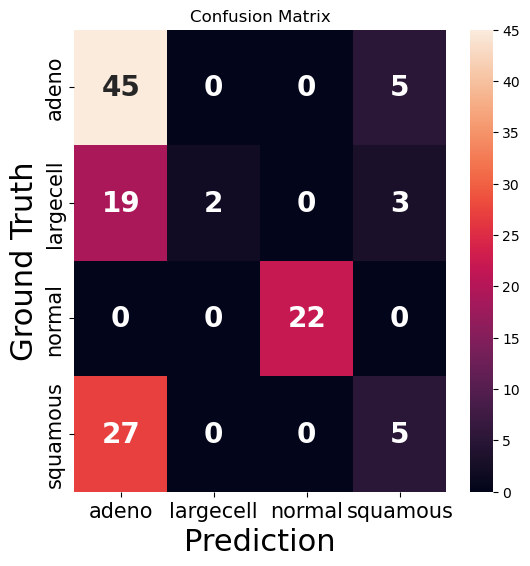

In [39]:

cm= confusion_matrix(y_true2, classes_x_comb1)
fig, ax = plt.subplots(figsize=(6,6))  
ax.set(title = "Confusion Matrix")
sns.heatmap(cm,annot =True,ax=ax, annot_kws={"size":20,"weight":"bold"})
labels=["adeno","largecell","normal","squamous"]
ax.set_xticklabels(labels,fontsize =15);
ax.set_yticklabels(labels,fontsize =15);
ax.set_ylabel('Ground Truth',fontsize =22);
ax.set_xlabel('Prediction',fontsize =22);

In [ ]:
Potential normal 